In [ ]:
import argparse
import numpy as np
import pandas as pd
import os
import sys
import librosa
import matplotlib.pyplot as plt
import librosa.display
import scipy.misc
import math
import imageio
import cv2 as cv
from scipy.misc import imsave
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
PATH_STFT='./stft3/'
IMAGE_WIDTH=227#308
IMAGE_HEIGHT=227#1025
IMAGE_SIZE=(IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS=3

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
MAX_SIZE_DURATION=157409

Using TensorFlow backend.


In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')


import os
os.chdir('/content/drive/My Drive/PIR')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


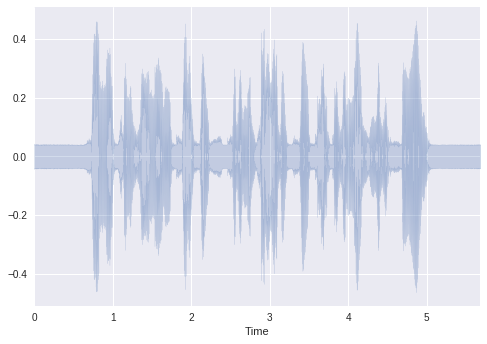

In [ ]:
MAX_DURATION=5.131609977324263 # determiné en balayant tout les fichiers sur d014
y,sr = librosa.load("./dataset/AudioData/DC/d14.wav")

librosa.display.waveplot(y, sr=sr, alpha=0.25)




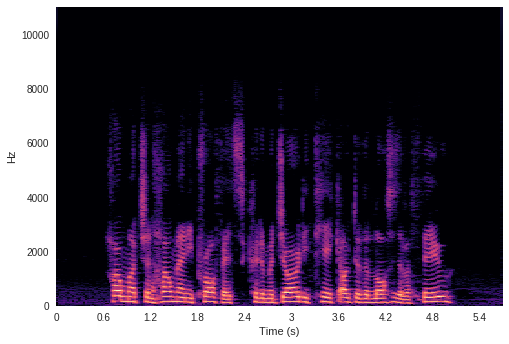

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear',x_axis='s')

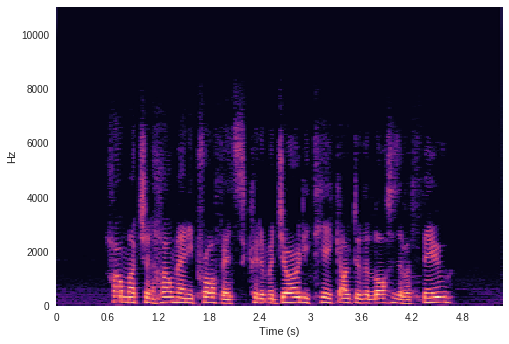

In [ ]:
D = cv.resize(D,(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv.INTER_CUBIC)
librosa.display.specshow(D, y_axis='linear',x_axis='s')

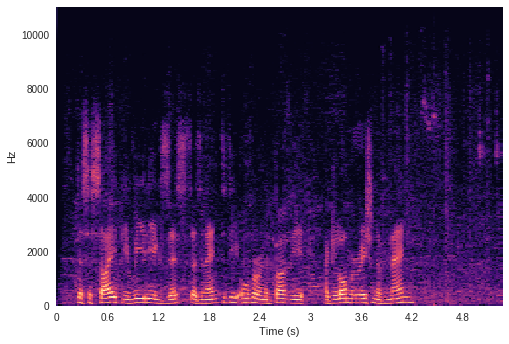

In [ ]:
D=cv.imread('./stft3/d15_stft_01.png')
D1=D[:,:,0]
librosa.display.specshow(D1, y_axis='linear',x_axis='s')

In [ ]:
def noise_track(path):
  i=0
  random_noise=[]
  for audio_file in os.listdir(path):
    size_noise=MAX_SIZE_DURATION+1
    audio_path=os.path.abspath(os.path.join(path,audio_file))
    y,sr = librosa.load(audio_path)
    l=len(y)
    
    for i in range(l//(size_noise)):
      a=y[i*size_noise:(i+1)*size_noise]
      random_noise.append(a)
  return random_noise
  
  

In [ ]:
path00='/content/drive/My Drive/PIR/background_noise'
audiofile00='mall.wav'
audio_path00=os.path.abspath(os.path.join(path00,audiofile00))
print(audio_path00)

/content/drive/My Drive/PIR/background_noise/mall.wav


In [ ]:
def make_df(savee_path):
            data_dir = '/content/drive/My Drive/PIR/dataset'
            speaker_ids = ['DC', 'JE', 'JK', 'KL']
            emotion_ids = ['a', 'd', 'f', 'h', 'n', 'sa', 'su']
            
            uttids = ['{0}_{1}_{2:02d}'.format(speaker, emotion, num)
                  for speaker in speaker_ids
                  for emotion in emotion_ids
                  for num in range(1, 16)]
            uttids.extend(['{0}_n_{1:02d}'.format(speaker, num)
                  for speaker in speaker_ids
                  for num in range(16, 31)])
            uttids.sort()
            filenames=[]
            label=[]
            num=np.array([])
            dur=[]
            df=[]
            #arr_max_duration=np.zeros(MAX_SIZE_DURATION)
            num_write=np.zeros(7)
            noise_samples=noise_track('/content/drive/My Drive/PIR/background_noise')
            #augmentation_number=len(test)
            for uttid in uttids:
              speaker = uttid.split('_')[0]
              em = uttid.split('_')[1]
              incr=np.array([int(emotion==em) for emotion in emotion_ids])
              num_write+=incr
              num=uttid.split('_')[2]
              
              label.append(em)
              #label.append(em)
              #label.append(em)
              
              
              # Fs, wav, wav_duration and normalize wav to [-1,1]
              wavpath = os.path.abspath(os.path.join(data_dir,
                                              'AudioData',
                                    speaker, em +num + '.wav'))
              
              audiofile,sr = librosa.load(wavpath)
              #print(MAX_SIZE_DURATION-len(audiofile)+1)
              audiofile=np.pad(audiofile, (0,MAX_SIZE_DURATION-len(audiofile)+1), 'constant', constant_values=(0))
              #print(em +num + '.wav')
              
              #for i in range(2):
              audiofile1=audiofile+np.random.randint(3)*noise_samples[np.random.randint(5)]/10
                #audiofile2=audiofile+np.random.randint(3)*noise_samples[np.random.randint(5)]/10
                #audiofile3=audiofile+np.random.randint(3)*noise_samples[np.random.randint(5)]/10
                
              
              stft1=librosa.amplitude_to_db(np.abs(librosa.stft(audiofile1)), ref=np.max)
              #stft2=librosa.amplitude_to_db(np.abs(librosa.stft(audiofile2)), ref=np.max)
              #stft3=librosa.amplitude_to_db(np.abs(librosa.stft(audiofile3)), ref=np.max)
              
              stft1 = cv.resize(stft1,(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv.INTER_CUBIC)
              #duration_audio=librosa.get_duration(S=stft, sr=sr)
              
              file_name1=em+'{0:02d}'.format(int(np.max(incr*num_write)))+'_stft_01.png'
              #file_name2=em+'{0:02d}'.format(int(np.max(incr*num_write)))+'_stft_02.jpg'
              #file_name3=em+'{0:02d}'.format(int(np.max(incr*num_write)))+'_stft_03.jpg'
              
              
              imsave('./stft3/'+file_name1, stft1)
              print(file_name1)
              #imageio.imwrite('./stft3/'+file_name1, stft1)
              #imageio.imwrite('./stft/'+file_name2, stft2)
              #imageio.imwrite('./stft/'+file_name3, stft3)
              
              #dur.append(duration_audio)
              
              filenames.append(file_name1)
              #filenames.append(file_name2)
              #filenames.append(file_name3)
              
              df = pd.DataFrame({
                'filename': filenames,
                'category': label
              })
            return df
              


In [ ]:
df=make_df("./dataset/AudioData")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


a01_stft_01.png
a02_stft_01.png
a03_stft_01.png
a04_stft_01.png
a05_stft_01.png
a06_stft_01.png
a07_stft_01.png
a08_stft_01.png
a09_stft_01.png
a10_stft_01.png
a11_stft_01.png
a12_stft_01.png
a13_stft_01.png
a14_stft_01.png
a15_stft_01.png
d01_stft_01.png
d02_stft_01.png
d03_stft_01.png
d04_stft_01.png
d05_stft_01.png
d06_stft_01.png
d07_stft_01.png
d08_stft_01.png
d09_stft_01.png
d10_stft_01.png
d11_stft_01.png
d12_stft_01.png
d13_stft_01.png
d14_stft_01.png
d15_stft_01.png
f01_stft_01.png
f02_stft_01.png
f03_stft_01.png
f04_stft_01.png
f05_stft_01.png
f06_stft_01.png
f07_stft_01.png
f08_stft_01.png
f09_stft_01.png
f10_stft_01.png
f11_stft_01.png
f12_stft_01.png
f13_stft_01.png
f14_stft_01.png
f15_stft_01.png
h01_stft_01.png
h02_stft_01.png
h03_stft_01.png
h04_stft_01.png
h05_stft_01.png
h06_stft_01.png
h07_stft_01.png
h08_stft_01.png
h09_stft_01.png
h10_stft_01.png
h11_stft_01.png
h12_stft_01.png
h13_stft_01.png
h14_stft_01.png
h15_stft_01.png
n01_stft_01.png
n02_stft_01.png
n03_stft

In [ ]:
df.head

<bound method NDFrame.head of     category          filename
0          a   a01_stft_01.png
1          a   a02_stft_01.png
2          a   a03_stft_01.png
3          a   a04_stft_01.png
4          a   a05_stft_01.png
5          a   a06_stft_01.png
6          a   a07_stft_01.png
7          a   a08_stft_01.png
8          a   a09_stft_01.png
9          a   a10_stft_01.png
10         a   a11_stft_01.png
11         a   a12_stft_01.png
12         a   a13_stft_01.png
13         a   a14_stft_01.png
14         a   a15_stft_01.png
15         d   d01_stft_01.png
16         d   d02_stft_01.png
17         d   d03_stft_01.png
18         d   d04_stft_01.png
19         d   d05_stft_01.png
20         d   d06_stft_01.png
21         d   d07_stft_01.png
22         d   d08_stft_01.png
23         d   d09_stft_01.png
24         d   d10_stft_01.png
25         d   d11_stft_01.png
26         d   d12_stft_01.png
27         d   d13_stft_01.png
28         d   d14_stft_01.png
29         d   d15_stft_01.png
..       

In [ ]:
def create_train_val(ratio,data_frame,number_noise):
  print(len(data_frame))
  n=int(len(data_frame)/number_noise)
  print(n)
  val0=random.sample(range(n), math.ceil(n*ratio))
  val0 = list(map(lambda x: x*number_noise, val0))
  val1 = list(map(lambda x: x+1, val0))
  val2 = list(map(lambda x: x+2, val0))
  
  
  validate_list=val0+val1+val2
  validate_list=np.sort(validate_list)
  print(validate_list)
  train_df=data_frame
  train_df=train_df.drop(train_df.index[validate_list])
  val_df=data_frame.iloc[validate_list]
  return(train_df,val_df)

In [ ]:
a=[0,1]
df0.index[1]

1

In [ ]:
df0=pd.read_pickle("./df/df_file_noise0.1")

df1,df2=create_train_val(0.3,df0,3)

1440
480
[  24   25   26   39   40   41   54   55   56   63   64   65   66   67
   68   75   76   77   87   88   89   96   97   98   99  100  101  102
  103  104  120  121  122  123  124  125  126  127  128  132  133  134
  138  139  140  141  142  143  147  148  149  162  163  164  165  166
  167  168  169  170  180  181  182  186  187  188  195  196  197  216
  217  218  243  244  245  264  265  266  270  271  272  276  277  278
  285  286  287  288  289  290  303  304  305  306  307  308  312  313
  314  327  328  329  333  334  335  336  337  338  345  346  347  360
  361  362  399  400  401  402  403  404  405  406  407  417  418  419
  426  427  428  450  451  452  456  457  458  459  460  461  465  466
  467  477  478  479  507  508  509  510  511  512  516  517  518  522
  523  524  528  529  530  540  541  542  543  544  545  546  547  548
  552  553  554  555  556  557  570  571  572  573  574  575  579  580
  581  603  604  605  609  610  611  627  628  629  633  634  635  6

In [ ]:
df2.head
#len(df1)

<bound method NDFrame.head of     category          filename
218        n   n13_stft_03.jpg
177        h   h15_stft_01.jpg
184        n   n02_stft_02.jpg
346       su  su11_stft_02.jpg
189        n   n04_stft_01.jpg
47         d   d01_stft_03.jpg
266        n   n29_stft_03.jpg
136        h   h01_stft_02.jpg
271       sa  sa01_stft_02.jpg
258        n   n27_stft_01.jpg
399        a   a29_stft_01.jpg
29         a   a10_stft_03.jpg
340       su  su09_stft_02.jpg
412        d   d18_stft_02.jpg
300       sa  sa11_stft_01.jpg
153        h   h07_stft_01.jpg
335       su  su07_stft_03.jpg
45         d   d01_stft_01.jpg
203        n   n08_stft_03.jpg
473        f   f23_stft_03.jpg
219        n   n14_stft_01.jpg
329       su  su05_stft_03.jpg
272       sa  sa01_stft_03.jpg
101        f   f04_stft_03.jpg
368        a   a18_stft_03.jpg
13         a   a05_stft_02.jpg
446        d   d29_stft_03.jpg
420        d   d21_stft_01.jpg
316       su  su01_stft_02.jpg
413        d   d18_stft_03.jpg
..       

In [ ]:
df['label']=[max(a*[1,2,3,4,5,6,7]) for a in df['category']]

In [ ]:
df_test=df
emotion_ids = ['an', 'di', 'fe', 'ha', 'ne', 'sa', 'su']
cat=list(df_test['category'])
cat=np.max([truc*np.array([0,1,2,3,4,5,6]) for truc in cat],axis=1)
cat=[emotion_ids[i] for i in cat]
df_test['category']=cat

In [ ]:
print(df.iloc[10,1])

a11_stft.jpg


In [ ]:
print(np.shape(load_img('./stft3/'+df.iloc[0,1])))
print(np.shape(load_img('./stft3/'+df.iloc[2,1])))
print(np.shape(load_img('./stft3/'+df.iloc[300,1])))

(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


In [ ]:
df.to_pickle("./df/df_file_dernier")


In [ ]:
df=pd.read_pickle("./df/df_file_dernier")

In [ ]:

batch_size=16


In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.initializers import glorot_normal

In [ ]:
model = Sequential()

model.add(Conv2D(96, (7, 7), strides=2, activation='relu', kernel_initializer=glorot_normal(seed=None), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Conv2D(384, (5,5), strides=2, kernel_initializer=glorot_normal(seed=1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))

model.add(Conv2D(384, (5,5), strides=2, kernel_initializer=glorot_normal(seed=1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(384, (3,3), strides=2, kernel_initializer=glorot_normal(seed=1), activation='relu'))
model.add(BatchNormalization())



#model.add(Conv2D(384, (3,1), strides=2, kernel_initializer=glorot_normal(seed=1), activation='relu'))
#model.add(Conv2D(384, (3,1), strides=2, kernel_initializer=glorot_normal(seed=1), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 1),strides=1))




#model.add(Conv2D(384, (3,3), strides=2,activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(7, activation='softmax'))

sgd = optimizers.SGD(lr=0.008, decay=1e-5, momentum=0.8, nesterov=True)
adm=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 111, 111, 96)      14208     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 111, 111, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 55, 55, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 384)       921984    
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 26, 26, 384)       1536      
_________________________________________________________________
max_

In [ ]:
Speech Emotion Recognition using Convolutional Neural Network

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    PATH_STFT, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 336 images belonging to 7 classes.


In [ ]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    PATH_STFT, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 144 images belonging to 7 classes.


In [ ]:
epochs=100
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
10/21 [=============>................] - ETA: 1:03 - loss: 2.0298 - categorical_accuracy: 0.1813

KeyboardInterrupt: ignored

In [ ]:
model1=model

In [ ]:
model1.load_weights('./modeles/my_model_0.7.h5')


In [ ]:
tf.keras.models.save_model(
    model1,
    './modeles/bes_model_0.7',
    overwrite=True,
    include_optimizer=True
)


In [ ]:
model3=tf.keras.models.load_model('./modeles/bes_model_0.7')


In [ ]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 111, 111, 96)      14208     
_________________________________________________________________
batch_normalization_v1_24 (B (None, 111, 111, 96)      384       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_v1_25 (B (None, 55, 55, 96)        384       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 26, 26, 384)       921984    
_________________________________________________________________
batch_normalization_v1_26 (B (None, 26, 26, 384)       1536      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 384)       0         
__________

In [ ]:
epochs=100
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
history = model3.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/100
21/21 [==============================] - 62s 3s/step - loss: 0.6272 - categorical_accuracy: 0.7798 - val_loss: 0.7944 - val_categorical_accuracy: 0.7361
Epoch 2/100
21/21 [==============================] - 6s 270ms/step - loss: 0.5329 - categorical_accuracy: 0.8333 - val_loss: 1.0546 - val_categorical_accuracy: 0.7014
Epoch 3/100
21/21 [==============================] - 9s 436ms/step - loss: 0.6193 - categorical_accuracy: 0.7798 - val_loss: 1.3275 - val_categorical_accuracy: 0.5486
Epoch 4/100
21/21 [==============================] - 9s 452ms/step - loss: 0.5453 - categorical_accuracy: 0.8036 - val_loss: 0.8372 - val_categorical_accuracy: 0.7292
Epoch 5/100
21/21 [==============================] - 9s 444ms/step - loss: 0.5159 - categorical_accuracy: 0.7857 - val_loss: 0.8599 - val_categorical_accuracy: 0.7153
Epoch 6/100
21/21 [==============================] - 10s 496ms/step - loss: 0.4864 - categorical_accuracy: 0.8185 - val_loss: 1.1975 - val_categorical_accuracy: 0.5694

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(
    model3,
    './modeles/bes_model_0.7.56',
    overwrite=True,
    include_optimizer=True
)

In [ ]:
emotion_ids=['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
conf_matrix=np.zeros([7,7])
for i in range(9):
  x,y=validation_generator[i]
  y_true=[emotion_ids[arg] for arg in np.argmax(y,axis=1)]
  y_pred=[emotion_ids[arg] for arg in np.argmax(model3.predict(x),axis=1)]
  
  conf_matrix+=confusion_matrix(y_true, y_pred, labels=emotion_ids)
conf_matrix

array([[13.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1., 10.,  1.,  1.,  4.,  0.,  1.],
       [ 1.,  4.,  8.,  1.,  1.,  0.,  3.],
       [ 0.,  1.,  0., 15.,  0.,  0.,  0.],
       [ 1.,  3.,  0.,  0., 38.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  6., 12.,  1.],
       [ 2.,  1.,  0.,  0.,  2.,  0., 10.]])

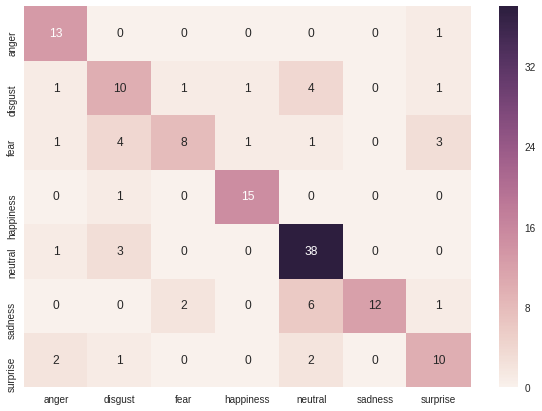

In [ ]:

array = conf_matrix
df_cm = pd.DataFrame(array, index = [i for i in emotion_ids],
                  columns = [i for i in emotion_ids])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
batch_size

16

In [ ]:
emotion_ids = 


['n',
 'sa',
 'f',
 'f',
 'su',
 'a',
 'a',
 'su',
 'a',
 'sa',
 'n',
 'n',
 'd',
 'n',
 'a',
 'f']

In [ ]:

confusion_matrix(y_true, y_pred)

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    PATH_STFT, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


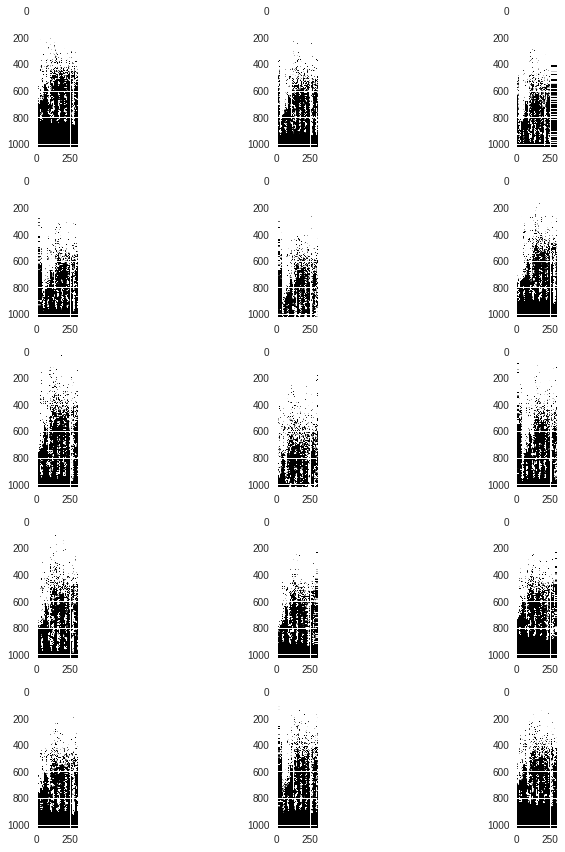

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()